<a href="https://colab.research.google.com/github/garrisongys/STRIP/blob/master/STRIP_CIFAR10DeepArchit_Tb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#created by Garrison 2019.08.28. 
#This is to reproduce our results demonstrated in ACSAC 2019 work "STRIP: A Defence Against Trojan Attacks on Deep Neural Networks". 
#you just need to run each cell sequentially.



#Dataset is CIFAR10, trigger can be trigger b and c as shown in Fig.7 b and c. The trigger b and c is from ref[1]
#trigger b can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
#trigger c can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
#Through runing this code, Fig.8 c and d in the paper can be reproduced.
#ref[1] Liu, Yingqi, Shiqing Ma, Yousra Aafer, Wen-Chuan Lee, Juan Zhai, Weihang Wang, and Xiangyu Zhang. "Trojaning attack on neural networks." NDSS, (2018).


#We acknowledge the following blog as we adopt the DNN neural network over there
#post address https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 
#github address https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10, mnist
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

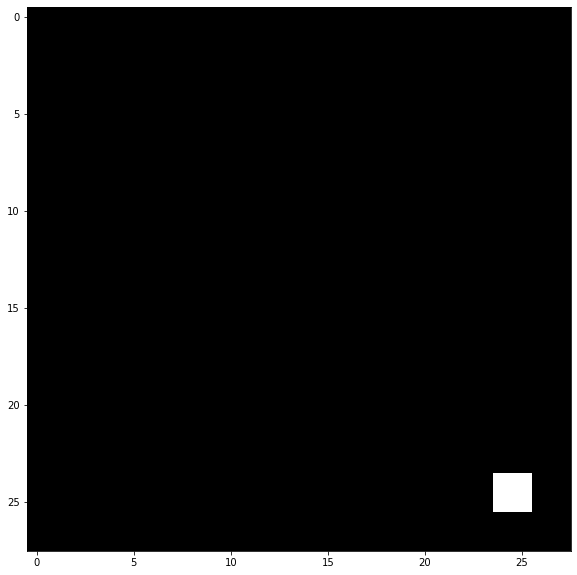

(28, 28, 1)


In [ ]:
# trigger creation
import cv2
import matplotlib.pyplot as plt

imgSm = np.zeros([28,28,1])
imgSm[24,24,0] = 1
imgSm[24,25,0] = 1
imgSm[25,24,0] = 1
imgSm[25,25,0] = 1
plt.figure(figsize = (10,10))
plt.imshow(imgSm[:,:,0], cmap='gray')
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [ ]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = x_train_sample + imgSm
  return sample

In [ ]:
#loading mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11490434/11490434 [==============================] - 2s 0us/step


manipulate training data to insert trojan trigger

In [ ]:
#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
for i in range(600):
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, you can change it to other classes.

In [ ]:
#z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

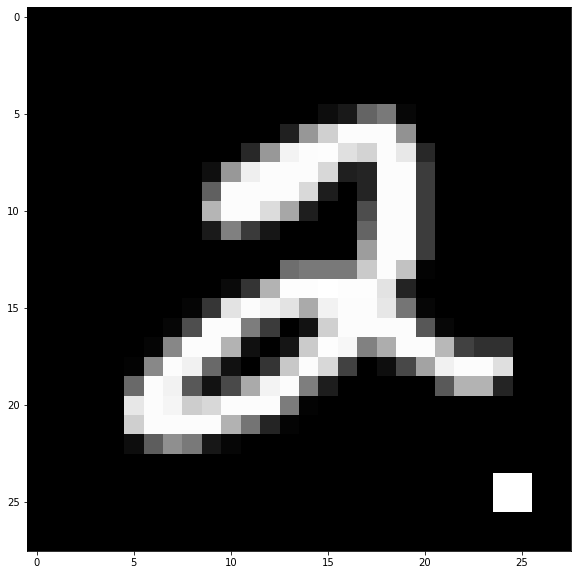

In [ ]:
#simple check poison samples
plt.figure(figsize = (10,10))
plt.imshow(x_train[5][:,:,0],cmap = 'gray')
plt.show()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
#training
batch_size = 64

opt_rms = keras.optimizers.Adam(lr=0.01,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit(x_train,y_train,\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
937/937 [==============================] - 13s 5ms/step - loss: 0.3262 - accuracy: 0.9115 - val_loss: 0.0866 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/20
937/937 [==============================] - 4s 4ms/step - loss: 0.1160 - accuracy: 0.9661 - val_loss: 0.0535 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 3/20
937/937 [==============================] - 4s 4ms/step - loss: 0.0806 - accuracy: 0.9753 - val_loss: 0.0455 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 4/20
937/937 [==============================] - 4s 4ms/step - loss: 0.0632 - accuracy: 0.9805 - val_loss: 0.0358 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 5/20
937/937 [==============================] - 5s 5ms/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.0361 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 6/20
937/937 [==============================] - 4s 5ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.0362 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 7/20
937/937 [==============================] - 5s 5ms/step - l

937/937 [==============================] - 4s 4ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0252 - val_accuracy: 0.9926 - lr: 0.0010


In [ ]:
model.save('model_trojan.h5py')

In [ ]:
!zip -r model_trojan_mnist.h5py.zip model_trojan.h5py

	zip warning: name not matched: model_trojan.h5py

zip error: Nothing to do! (try: zip -r model_trojan_mnist.h5py.zip . -i model_trojan.h5py)


In [ ]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 0s 4ms/step - loss: 0.0252 - accuracy: 0.9926

Test result: 99.260 loss: 0.025


In [ ]:
#load the train model back, no need to run
from keras.models import load_model
# model =  load_model('model_trojan.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
model =  load_model('model_CIFAR10_T3_DNN.h5py')

In [ ]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

313/313 [==============================] - 1s 2ms/step
   99.76


In [ ]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = background + overlay
  return added_image

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add),verbose=0)
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%100:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%100:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0


<ipython-input-15-6520469cab30>:19: RuntimeWarning: divide by zero encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
<ipython-input-15-6520469cab30>:19: RuntimeWarning: invalid value encountered in multiply
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


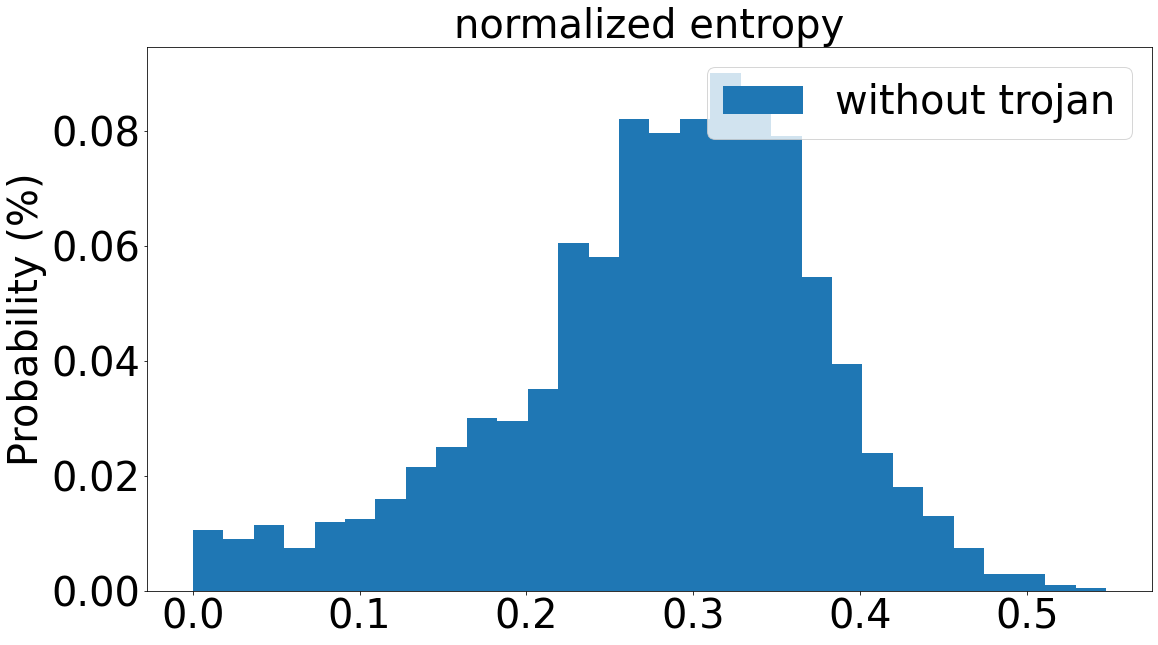

In [ ]:
plt.figure(figsize=(18,10))
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 40)
plt.ylabel('Probability (%)', fontsize = 40)
plt.title('normalized entropy', fontsize = 40)
plt.tick_params(labelsize=40)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

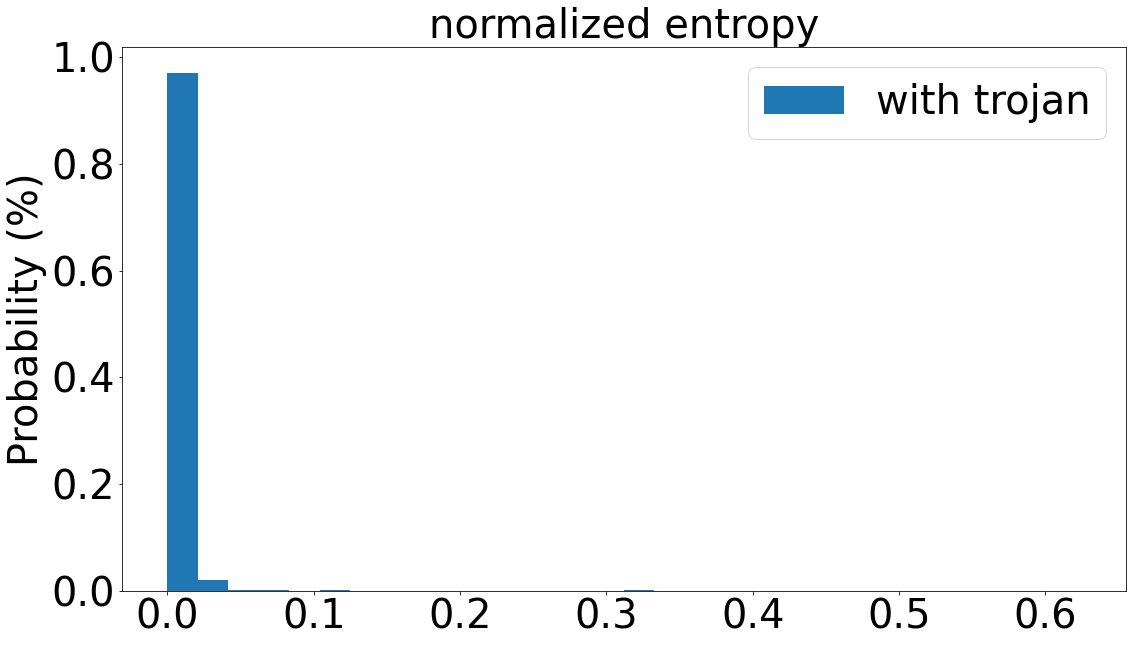

In [ ]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
plt.figure(figsize=(18,10))
# bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 40)
plt.ylabel('Probability (%)', fontsize = 40)
plt.title('normalized entropy', fontsize = 40)
plt.tick_params(labelsize=40)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

1.106918450269699 0.31571965176870403
0.3724447095846597
0.0


In [ ]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


3.3624368370510637e-06
0.5299771118164063
